In [1]:
%pip install --quiet -U langgraph langchain_anthropic

Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


In [3]:
from typing import List

from langchain_core.messages import SystemMessage
#from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

from pydantic import BaseModel

In [4]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = init_chat_model("claude-sonnet-4-5-20250929",temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            other_msgs.append(HumanMessage(content="Please produce the prompt template now."))
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [6]:
from typing import Literal
from langgraph.graph import END

def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [7]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = InMemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

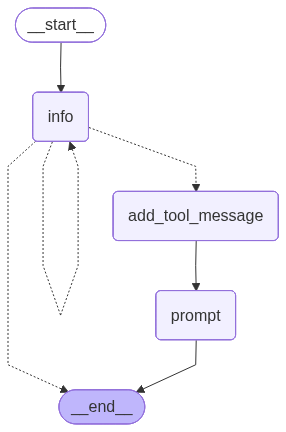

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    set_exit = False
    for output in graph.stream( {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates" ):
        last_message = next(iter(output.values()))["messages"][-1]
        if hasattr(last_message, "content"):
            if isinstance(last_message.content, list):
                texts = [part.get("text", "") for part in last_message.content if isinstance(part, dict) and "text" in part]
                print("AI:", " ".join(texts))
            else:
                print("AI:", last_message.content)
        else:
            print("AI:", last_message)


        if "Prompt generated" in last_message.content:
            set_exit = True

    if set_exit == True:
        print("Done!")
        break

User (q/Q to quit):  Hi


AI: Hello! I can help you create a prompt template. To get started, I need to gather some information about what you're looking for:

1. **Objective**: What is the main goal or purpose of this prompt? What do you want it to accomplish?

2. **Variables**: What dynamic information will be passed into this prompt template? (e.g., user input, topic, data, etc.)

3. **Constraints**: Are there any things the output should NOT do or avoid?

4. **Requirements**: Are there any specific things the output MUST do or include?

Could you tell me about what kind of prompt template you'd like to create?


User (q/Q to quit):  The objective is to call a tool for web search. The input variables are date and location and use serpapi for website search. The output should be a dictionary.


AI: Great! Let me clarify a few more details:

1. **Objective**: Call a tool for web search - got it!

2. **Variables**: `date` and `location` - perfect!

3. **Constraints**: What should the output NOT do? For example:
   - Should it not include certain types of information?
   - Should it not use certain formats?
   - Should it avoid any specific behaviors?

4. **Requirements**: I understand the output should be a dictionary and use serpapi for website search. Are there any other requirements? For example:
   - Should the dictionary have specific keys or structure?
   - Should it include specific information in the search results?
   - Any formatting requirements for the dictionary?
   - Should it handle errors in a specific way?

Could you provide more details on the constraints and any additional requirements?


User (q/Q to quit):  No specific requirements on constraints and no additional requirements.


AI: 
AI: Prompt generated!
AI: # Prompt Template for Web Search Tool

```python
"""
Web Search Tool Call Template using SerpAPI

This template is designed to call a web search tool using SerpAPI with specified parameters.
"""

PROMPT_TEMPLATE = """
You are a web search assistant that uses SerpAPI to retrieve information from the internet.

Your task is to perform a web search with the following parameters:

Date: {date}
Location: {location}

Instructions:
1. Use SerpAPI to search for relevant information based on the provided date and location
2. Construct an appropriate search query that incorporates both the date and location context
3. Return the results in a dictionary format

Output Format:
Your response must be a valid Python dictionary with the following structure:
{{
    "search_query": "the constructed search query",
    "date": "{date}",
    "location": "{location}",
    "results": [
        {{
            "title": "result title",
            "link": "result URL",
           